# [**Workflows for atomistic simulations**](http://potentials.rub.de/) 

## **Day 1 - Atomistic simulations with [pyiron](https://pyiron.org)**


### **Exercise 1: Introduction to atomistic simulations with pyiron**

Before the excercise, you should:

* Be familiar with python especially with numerical libraries like numpy and plotting tools like matplotlib
* Understand how Jupyter Notebooks work

The aim of this exercise is to make you familiar with:

* A general overview of what pyiron can do
* How to set up atomic structures and run atomistic simulation codes through pyiron

### **Importing necessary libraries**

As a first step we import the libraries [numpy](http://www.numpy.org/) for data analysis and [matplotlib](https://matplotlib.org/) for visualization.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

Fundamentally, we only need to import one module from `pyiron`: the `Project` class

In [2]:
from pyiron import Project

The Project object introduced below is central in pyiron. It allows to name the project as well as to derive all other objects such as structures, jobs etc. without having to import them. Thus, by code completion *Tab* the respective commands can be found easily.

We now create a pyiron Project named 'first_steps'.

### **Creation of a project instance**

In [3]:
pr = Project("first_steps")

The project name also applies for the directory that is created for the project. All data generated by this `Project` object resides in this directory.

In [4]:
pr.path

'/home/pyiron/day_1/first_steps/'

In [5]:
pr

{'groups': [], 'nodes': []}

### **Creating atomic structures**

Every atomistic simulation needs an atomic structure. For more details on generating and manipulating structures, please have a look at our [structures example](https://pyiron.readthedocs.io/en/latest/source/notebooks/structures.html). In this section however, we show how to generate and manipulate bulk crystals, surfaces, etc. pyiron's structure class is derived from the popular [`ase` package](https://wiki.fysik.dtu.dk/ase/ase/build/build.html) and any `ase` function to manipulate structures can also be applied here.

In [6]:
# Creating a bulk fcc cubic unitcell
Cu_unitcell_cubic = pr.create_ase_bulk('Cu', cubic=True, a=3.61)
Cu_unitcell_cubic

Cu: [0. 0. 0.]
Cu: [0.    1.805 1.805]
Cu: [1.805 0.    1.805]
Cu: [1.805 1.805 0.   ]
pbc: [ True  True  True]
cell: 
Cell([3.61, 3.61, 3.61])

In [7]:
Cu_supercell_3_3_3 = Cu_unitcell_cubic.repeat([3, 3, 3])
Cu_supercell_3_3_3.plot3d(particle_size=2)

NGLWidget()

In [8]:
# Creating a bulk fcc primitive unitcell and cupercell
Cu_unitcell_primitive = pr.create_ase_bulk('Cu', a=4.01)
Cu_unitcell_primitive.repeat([3, 3, 3]).plot3d(particle_size=2)

NGLWidget()

In [9]:
# Creating a vacancy in a supercell
Cu_vacancy = Cu_supercell_3_3_3.copy()
del Cu_vacancy[0] # Deleting the first atom
print(Cu_supercell_3_3_3.get_chemical_formula(), Cu_vacancy.get_chemical_formula())
Cu_vacancy.plot3d(particle_size=2)

Cu108 Cu107


NGLWidget()

In [10]:
# Creating a fcc111 surface supercell
num_layers = 4
Cu_fcc_111 = pr.create_surface("Cu", surface_type="fcc111", size=(4, 4, num_layers), vacuum=12, orthogonal=True)
Cu_fcc_111.plot3d(particle_size=2)

NGLWidget()

In [11]:
# Atom in a box
cell = np.eye(3) * 10
Cu_atom_box = pr.create_atoms("Cu", cell=cell, scaled_positions=[[0.5, 0.5, 0.5]])
Cu_atom_box.plot3d(particle_size=2)

NGLWidget()

In [12]:
# Cu-Cu dimer
cell = np.eye(3) * 10
Cu_atom_1 = pr.create_atoms("Cu", cell=cell, scaled_positions=[[0.5, 0.5, 0.5]])
Cu_atom_2 = Cu_atom_1.copy()

dimer_length = 2.5
Cu_atom_2.positions[:, 2] += dimer_length
Cu_dimer = Cu_atom_1 + Cu_atom_2
Cu_dimer.center()
Cu_dimer.plot3d()

NGLWidget()

### **Running an atomistic calculation using interatomic potentials (with LAMMPS)**

Once we have an atomic structure, we can set up a simulation "job" of any atomistic simulation that is intergrated within pyiron. In this section, we are going to use the popular [LAMMPS code](https://lammps.sandia.gov/).

In [13]:
# Create a job
job_lammps = pr.create.job.Lammps(job_name="lammps_job")

Every atomistic simulation code needs an input atomic structure. We use the Cu supercell structure we created earlier

In [14]:
# Assign an atomic structure to the job
job_lammps.structure = Cu_supercell_3_3_3

Once the structure is assigned, an appropriate potential should also be chosen. This list of available for the structure containing Cu can be found below

In [15]:
# See available potentials
job_lammps.list_potentials()[50:60]

['2016--Borovikov-V--fictional-Cu-31--LAMMPS--ipr1',
 '2016--Borovikov-V--fictional-Cu-32--LAMMPS--ipr1',
 '2016--Borovikov-V--fictional-Cu-33--LAMMPS--ipr1',
 '2016--Borovikov-V--fictional-Cu-34--LAMMPS--ipr1',
 '2016--Zhou-X-W--Al-Cu--LAMMPS--ipr2',
 '2017--Kim-J-S--Cu-Pt--LAMMPS--ipr1',
 '2018--Etesami-S-A--Cu--LAMMPS--ipr1',
 '2018--Farkas-D--Fe-Ni-Cr-Co-Cu--LAMMPS--ipr2',
 '2018--Jeong-G-U--Pd-Cu--LAMMPS--ipr1',
 '2018--Zhou-X-W--Al-Cu-H--LAMMPS--ipr1']

In [16]:
# Choose one of these potentials
job_lammps.potential = '2012--Mendelev-M-I--Cu--LAMMPS--ipr1'

At this stage, the computational parameters for the simulation needs to be specified. pyiron parses generic computational parameters into code specific parameters allowing for an easy transition between simulation codes

In [17]:
# specify calculation details: in this case: MD at 800 K in the NPT ensemble (pressure=0) for 10000 steps
job_lammps.calc_md(temperature=800, pressure=0, n_ionic_steps=10000)

We can now see how pyiron sets-up the corresponding LAMMPS input

In [18]:
job_lammps.input.control

,Parameter,Value,Comment
0,units,metal,
1,dimension,3,
2,boundary,p p p,
3,atom_style,atomic,
4,read_data,structure.inp,
5,include,potential.inp,
6,fix___ensemble,all npt temp 800.0 800.0 0.1 iso 0.0 0.0 1.0,
7,variable___dumptime,equal 100,
8,variable___thermotime,equal 100,
9,timestep,0.001,


Once the `run()` commmand is called, pyiron creates necessary input files, calls the simulation code, and finally parses and stores the output.

In [19]:
job_lammps.run()

The job lammps_job was saved and received the ID: 168


In [20]:
pr

{'groups': [], 'nodes': ['lammps_job']}

In [21]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,168,finished,Cu108,lammps_job,/lammps_job,/home/pyiron/,day_1/first_steps/,2021-03-09 09:30:08.840889,2021-03-09 09:30:15.206953,6.0,pyiron@jupyter-sudarsan#1,Lammps,0.1,None,None


## **Analysing a calculation**

In [22]:
# Load the job
job_loaded = pr['lammps_job']

In [23]:
job_loaded

{'groups': ['input', 'output'], 'nodes': ['HDF_VERSION', 'NAME', 'TYPE', 'VERSION', 'server', 'status']}

In [24]:
job_loaded["output/generic"]

{'groups': [], 'nodes': ['cells', 'energy_pot', 'energy_tot', 'forces', 'indices', 'positions', 'pressures', 'steps', 'temperature', 'unwrapped_positions', 'velocities', 'volume']}

In [25]:
final_struct = job_loaded.get_structure(iteration_step=-1)
final_struct.plot3d()

NGLWidget()

In [26]:
job_loaded.animate_structure()

NGLWidget(max_frame=100)

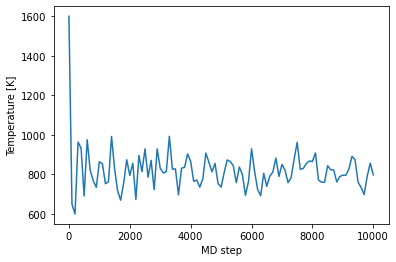

In [27]:
temperatures = job_loaded['output/generic/temperature']
steps = job_loaded['output/generic/steps']
plt.plot(steps, temperatures)
plt.xlabel('MD step')
plt.ylabel('Temperature [K]');

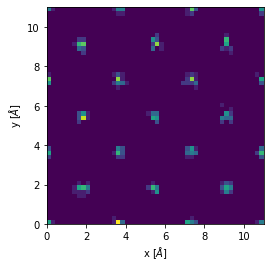

In [28]:
pos = job_loaded['output/generic/positions']
x, y, z = [pos[:, :, i] for i in range(3)]
sel = np.abs(z) < 0.1
fig, axs = plt.subplots(1,1)
axs.hist2d(x[sel], y[sel], bins=50)
axs.set_xlabel('x [$\AA$]')
axs.set_ylabel('y [$\AA$]')
axs.set_aspect('equal', 'box');

### **Running an atomistic calculation using DFT (with SPHInX)**

In [29]:
job_sphinx = pr.create.job.Sphinx("sphinx_job")
job_sphinx.structure = Cu_unitcell_primitive
job_sphinx.set_exchange_correlation_functional("PBE")
job_sphinx.plane_wave_cutoff = 350
job_sphinx.calc_static()
job_sphinx.run()

The job sphinx_job was saved and received the ID: 175


In [30]:
job_sphinx['output/generic/']

{'groups': ['dft'], 'nodes': ['cells', 'computation_time', 'energy_pot', 'energy_tot', 'forces', 'positions', 'volume']}

In [31]:
job_sphinx["output/generic/energy_tot"] # Energy for every ionic step

array([-5386.42735492])

In [32]:
job_sphinx['output/electronic_structure']

{'groups': ['dos'], 'nodes': ['TYPE', 'efermi', 'eig_matrix', 'k_points', 'k_weights', 'occ_matrix']}

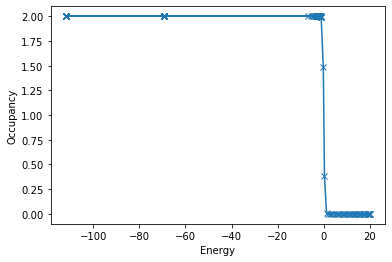

In [33]:
eigenvalues = job_sphinx['output/electronic_structure/eig_matrix'].flatten()
occupancies = job_sphinx['output/electronic_structure/occ_matrix'].flatten()

efermi = job_sphinx['output/electronic_structure/efermi']
args = np.argsort(occupancies)
plt.plot(eigenvalues[args] -efermi, occupancies[args], "-x")
plt.xlabel('Energy')
plt.ylabel('Occupancy');

## **Task 1: Energy volume curve for Al**

In [34]:
def get_volume(job):
    return job["output/generic/volume"][-1]

In [35]:
def get_energy(job):
    return job["output/generic/energy_tot"][-1]

In [36]:
get_energy(job_loaded), get_volume(job_loaded)

(-345.776978906089, 1337.89883612206)

In [37]:
pr_ev = pr.create_group("E_V_curve") # Creating a new sub-project within the main project
a_list = np.linspace(3.4, 4.0, 7)
for a in a_list:
    job_name = "job_a_{:.4}".format(a).replace(".", "_")
    job = pr_ev.create.job.Lammps(job_name)
    job.structure = pr_ev.create_ase_bulk("Cu", a=a)
    job.potential = '2012--Mendelev-M-I--Cu--LAMMPS--ipr1'
    job.calc_minimize()
    job.run()
    

The job job_a_3_4 was saved and received the ID: 176
The job job_a_3_5 was saved and received the ID: 177
The job job_a_3_6 was saved and received the ID: 178
The job job_a_3_7 was saved and received the ID: 180
The job job_a_3_8 was saved and received the ID: 183
The job job_a_3_9 was saved and received the ID: 185
The job job_a_4_0 was saved and received the ID: 188


In [38]:
pr.list_groups(), pr.list_nodes()

(['E_V_curve'], ['lammps_job', 'sphinx_job'])

In [39]:
pr_ev.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,176,finished,Cu,job_a_3_4,/job_a_3_4,/home/pyiron/,day_1/first_steps/E_V_curve/,2021-03-09 09:30:22.540993,2021-03-09 09:30:22.956864,0.0,pyiron@jupyter-sudarsan#1,Lammps,0.1,None,None
1,177,finished,Cu,job_a_3_5,/job_a_3_5,/home/pyiron/,day_1/first_steps/E_V_curve/,2021-03-09 09:30:23.763351,2021-03-09 09:30:24.226511,0.0,pyiron@jupyter-sudarsan#1,Lammps,0.1,None,None
2,178,finished,Cu,job_a_3_6,/job_a_3_6,/home/pyiron/,day_1/first_steps/E_V_curve/,2021-03-09 09:30:25.307550,2021-03-09 09:30:25.811752,0.0,pyiron@jupyter-sudarsan#1,Lammps,0.1,None,None
3,180,finished,Cu,job_a_3_7,/job_a_3_7,/home/pyiron/,day_1/first_steps/E_V_curve/,2021-03-09 09:30:27.023289,2021-03-09 09:30:27.631846,0.0,pyiron@jupyter-sudarsan#1,Lammps,0.1,None,None
4,183,finished,Cu,job_a_3_8,/job_a_3_8,/home/pyiron/,day_1/first_steps/E_V_curve/,2021-03-09 09:30:29.352758,2021-03-09 09:30:29.904205,0.0,pyiron@jupyter-sudarsan#1,Lammps,0.1,None,None
5,185,finished,Cu,job_a_3_9,/job_a_3_9,/home/pyiron/,day_1/first_steps/E_V_curve/,2021-03-09 09:30:31.536258,2021-03-09 09:30:32.210804,0.0,pyiron@jupyter-sudarsan#1,Lammps,0.1,None,None
6,188,finished,Cu,job_a_4_0,/job_a_4_0,/home/pyiron/,day_1/first_steps/E_V_curve/,2021-03-09 09:30:34.056451,2021-03-09 09:30:34.612759,0.0,pyiron@jupyter-sudarsan#1,Lammps,0.1,None,None


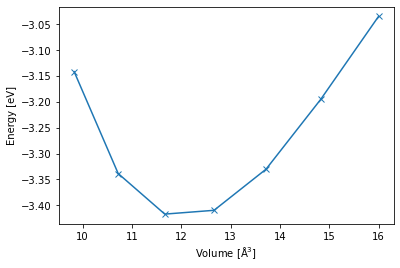

In [40]:
# Analysing the data
vol_list = list()
energy_list = list()

for job in pr["E_V_curve"].iter_jobs(status="finished"):
    vol_list.append(get_volume(job))
    energy_list.append(get_energy(job))

args = np.argsort(vol_list)
vol_list = np.array(vol_list)
energy_list = np.array(energy_list)
plt.plot(vol_list[args], energy_list[args], "-x")
plt.xlabel("Volume [$\mathrm{\AA^3}$]")
plt.ylabel("Energy [eV]");

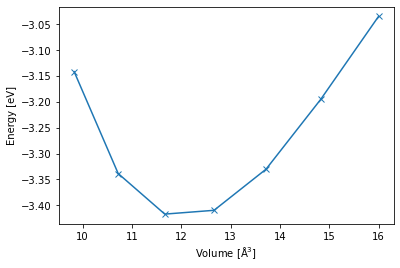

In [41]:
# Analysing the data
vol_list = list()
energy_list = list()

for job in pr["E_V_curve"].iter_jobs(convert_to_object=False, status="finished"):
    vol_list.append(get_volume(job))
    energy_list.append(get_energy(job))

args = np.argsort(vol_list)
vol_list = np.array(vol_list)
energy_list = np.array(energy_list)
plt.plot(vol_list[args], energy_list[args], "-x")
plt.xlabel("Volume [$\mathrm{\AA^3}$]")
plt.ylabel("Energy [eV]");

## **Task 2: E-V curves for DFT**

In [42]:
pr_ev = pr.create_group("E_V_curve_DFT") # Creating a new sub-project within the main project
a_list = np.linspace(3.4, 4.0, 7)
for a in a_list:
    job_name = "job_a_{:.4}".format(a).replace(".", "_")
    job = pr_ev.create.job.Sphinx(job_name)
    job.structure = pr_ev.create_ase_bulk("Cu", a=a)
    job.set_exchange_correlation_functional("PBE")
    job.plane_wave_cutoff = 350
    job.set_kpoints(mesh=[4, 4, 4])
    job.set_occupancy_smearing("fermi", 0.1)
    job.calc_minimize()
    job.run()
    

The job job_a_3_4 was saved and received the ID: 193


/opt/conda/lib/python3.8/site-packages/pyiron_base/generic/hdfio.py:718: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([np.array(v) for v in value]),


The job job_a_3_5 was saved and received the ID: 198


/opt/conda/lib/python3.8/site-packages/pyiron_base/generic/hdfio.py:718: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([np.array(v) for v in value]),


The job job_a_3_6 was saved and received the ID: 199


/opt/conda/lib/python3.8/site-packages/pyiron_base/generic/hdfio.py:718: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([np.array(v) for v in value]),


The job job_a_3_7 was saved and received the ID: 201


/opt/conda/lib/python3.8/site-packages/pyiron_base/generic/hdfio.py:718: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([np.array(v) for v in value]),


The job job_a_3_8 was saved and received the ID: 207


/opt/conda/lib/python3.8/site-packages/pyiron_base/generic/hdfio.py:718: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([np.array(v) for v in value]),


The job job_a_3_9 was saved and received the ID: 213


/opt/conda/lib/python3.8/site-packages/pyiron_base/generic/hdfio.py:718: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([np.array(v) for v in value]),


The job job_a_4_0 was saved and received the ID: 217


/opt/conda/lib/python3.8/site-packages/pyiron_base/generic/hdfio.py:718: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([np.array(v) for v in value]),


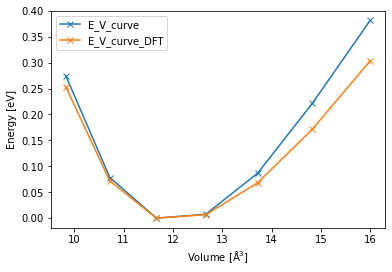

In [43]:
# Analysing the data
group_list = pr.list_groups()

for group in group_list:
    vol_list = list()
    energy_list = list()
    for job in pr[group].iter_jobs(convert_to_object=False, status="finished"):
        vol_list.append(get_volume(job))
        energy_list.append(get_energy(job))
    args = np.argsort(vol_list)
    vol_list = np.array(vol_list)
    energy_list = np.array(energy_list)
    plt.plot(vol_list[args], energy_list[args] - np.min(energy_list), "-x", label=group)
plt.xlabel("Volume [$\mathrm{\AA^3}$]")
plt.ylabel("Energy [eV]")
plt.legend();

## **Advanced pyiron: Automated workflows and analysis tools**

While we could in principle obtain thee E-V cureves by setting up and analyzing the calculations manually as done above, we could also use predefined workflows in pyiron which does this automatically

In [44]:
num_pot = 3
pot_finder = pr.inspect_emperical_potentials()
pot_list = pot_finder.find("Cu").Name.to_list()[20:20+num_pot]
pot_list

['2004--Lee-B-J--Cu-Ni--LAMMPS--ipr1',
 '2004--Zhou-X-W--Cu--LAMMPS--ipr2',
 '2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2']

In [45]:
def clean_project_name(name):
    return name.replace("-", "_")

In [53]:
# Automated Murnaghan using pyiron tables

pr_murn = Project("murn_auto") 

for pot in pot_list:
    
    lammps_job = pr_murn.create.job.Lammps("lammps_ref")
    lammps_job.structure = pr.create_ase_bulk("Cu")
    lammps_job.potential = pot
    lammps_job.calc_minimize()
    
    # Creating a Murnaghan workflow (char names not to exceed 50 chars)
    job_name = "murn_ref_{}".format(clean_project_name(pot))[:40]
    
    # The job type 'Murnaghan' sets up the appropriate workflow 
    murn_job = lammps_job.create_job(pr.job_type.Murnaghan, job_name)
    murn_job.input["num_points"] = 9
    murn_job.run()

The job murn_ref_2004__Lee_B_J__Cu_Ni__LAMMPS__i was saved and received the ID: 236
The job strain_0_9 was saved and received the ID: 237
The job strain_0_925 was saved and received the ID: 238
The job strain_0_95 was saved and received the ID: 239
The job strain_0_975 was saved and received the ID: 240
The job strain_1_0 was saved and received the ID: 241
The job strain_1_025 was saved and received the ID: 243
The job strain_1_05 was saved and received the ID: 244
The job strain_1_075 was saved and received the ID: 245
The job strain_1_1 was saved and received the ID: 246
job_id:  237 finished
job_id:  238 finished
job_id:  239 finished
job_id:  240 finished
job_id:  241 finished
job_id:  243 finished
job_id:  244 finished
job_id:  245 finished
job_id:  246 finished
The job murn_ref_2004__Zhou_X_W__Cu__LAMMPS__ipr was saved and received the ID: 247
The job strain_0_9 was saved and received the ID: 248
The job strain_0_925 was saved and received the ID: 249
The job strain_0_95 was save

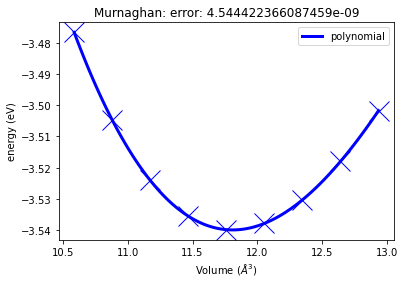

In [54]:
murn_job.plot()

In [55]:
murn_job["output/equilibrium_volume"], murn_job["output/equilibrium_bulk_modulus"]

(11.809747918737973, 135.83377204846934)

In [56]:
np.linalg.norm(murn_job["output/structure/cell/cell"][0]) * np.sqrt(2)

3.6149326164726543

We now analyze the data using our in-built pyiron tables class

In [57]:
# A filter function that selects only Murnaghan jobs
def get_only_murn(job_table):
    return (job_table.hamilton == "Murnaghan") & (job_table.status == "finished")

# Functions to obtain output from Murnaghan jobs
def get_eq_vol(job_path):
    return job_path["output/equilibrium_volume"]

def get_eq_lp(job_path):
    return np.linalg.norm(job_path["output/structure/cell/cell"][0]) * np.sqrt(2)

def get_eq_bm(job_path):
    return job_path["output/equilibrium_bulk_modulus"]

def get_potential(job_path):
    return job_path["lammps_ref/input/potential/Name"]

In [58]:
# Creating a pyiron table and processing output
table = pr_murn.create.table("table_murn", delete_existing_job=True)
table.db_filter_function = get_only_murn
table.add["potential"] = get_potential
table.add["a"] = get_eq_lp
table.add["eq_vol"] = get_eq_vol
table.add["eq_bm"] = get_eq_bm

table.run()
table.get_dataframe()

100%|██████████| 3/3 [00:00<00:00, 77.20it/s]

The job table_murn was saved and received the ID: 269


,job_id,potential,a,eq_vol,eq_bm
0,236,2004--Lee-B-J--Cu-Ni--LAMMPS--ipr1,3.521448,10.917012,179.040468
1,247,2004--Zhou-X-W--Cu--LAMMPS--ipr2,3.614921,11.809634,135.833414
2,258,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2,3.614933,11.809748,135.833772
